In [1]:
import pandas as pd 

In [2]:
#Pull raw july data + raw m1 data >> June data
raw_july_data = pd.read_excel('BrentTOD.xlsx', sheet_name = 'RawJuly24')
raw_m1_data = pd.read_excel('BrentTOD.xlsx', sheet_name='RawM1')

In [3]:
#Data Cleaning for raw july data

raw_july_data.columns = ['Unused1', 'Unused2', 'Timestamp', 'Price']


raw_july_data_cleaned = raw_july_data[['Timestamp', 'Price']].dropna()

raw_july_data_cleaned.reset_index(inplace = True, drop = True)
# Convert the 'Timestamp' column to datetime format
raw_july_data_cleaned['Timestamp'] = pd.to_datetime(raw_july_data_cleaned['Timestamp'])

# Display the cleaned data
raw_july_data_cleaned


Timestamp  Price
0     2024-05-23 16:05:00  81.89
1     2024-05-23 16:00:00  81.79
2     2024-05-23 15:55:00  81.77
3     2024-05-23 15:50:00  81.83
4     2024-05-23 15:45:00  81.77
...                   ...    ...
36361 2023-11-09 09:15:01  78.61
36362 2023-11-09 09:10:01  78.57
36363 2023-11-09 09:05:01  78.44
36364 2023-11-09 09:00:01  78.45
36365 2023-11-09 08:55:01  78.31

[36366 rows x 2 columns]

In [4]:
import matplotlib.pyplot as plt

# If plt.xlabel was overwritten
print(plt.xlabel)  # This should show <function ...> and not a list

# Resetting to the original function if it was overwritten
if not callable(plt.xlabel):
    from matplotlib.pyplot import xlabel
    plt.xlabel = xlabel

<function xlabel at 0x000001B6C2CABF60>


In [5]:
print(plt.xlabel)

<function xlabel at 0x000001B6C2CABF60>


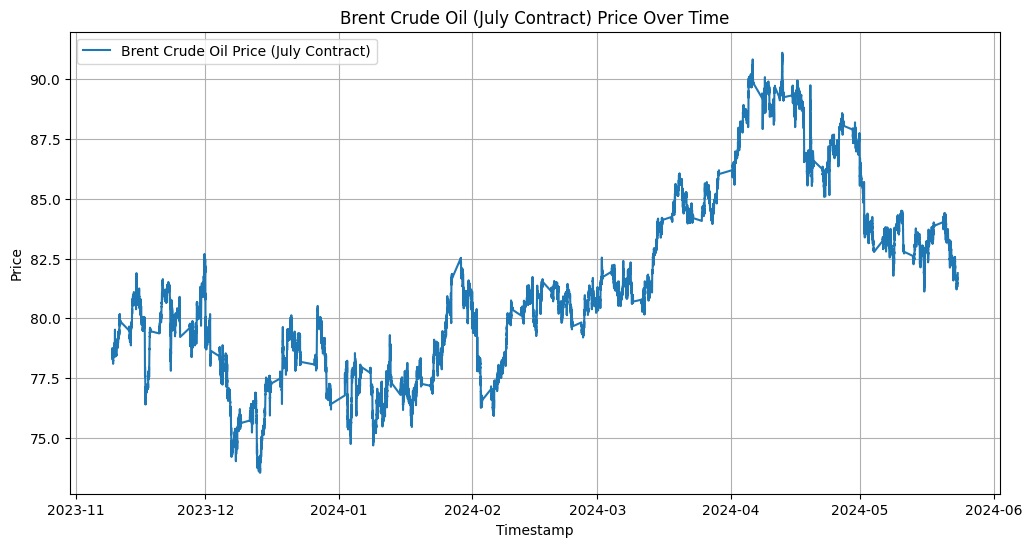

count    36366.000000
mean        81.359375
std          3.819442
min         73.550000
25%         78.360000
50%         80.820000
75%         83.890000
max         91.100000
Name: Price, dtype: float64


In [6]:
# Preliminary Analysis

import matplotlib.pyplot as plt

# Plot the time series data
plt.figure(figsize=(12, 6))
plt.plot(raw_july_data_cleaned['Timestamp'], raw_july_data_cleaned['Price'], label='Brent Crude Oil Price (July Contract)')
plt.xlabel("Timestamp")
plt.ylabel('Price')
plt.title('Brent Crude Oil (July Contract) Price Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Calculate basic descriptive statistics
descriptive_stats = raw_july_data_cleaned['Price'].describe()
print(descriptive_stats)

Text(0.5, 1.0, 'Rolling Standard Deviation Moving Average (30 time steps)')

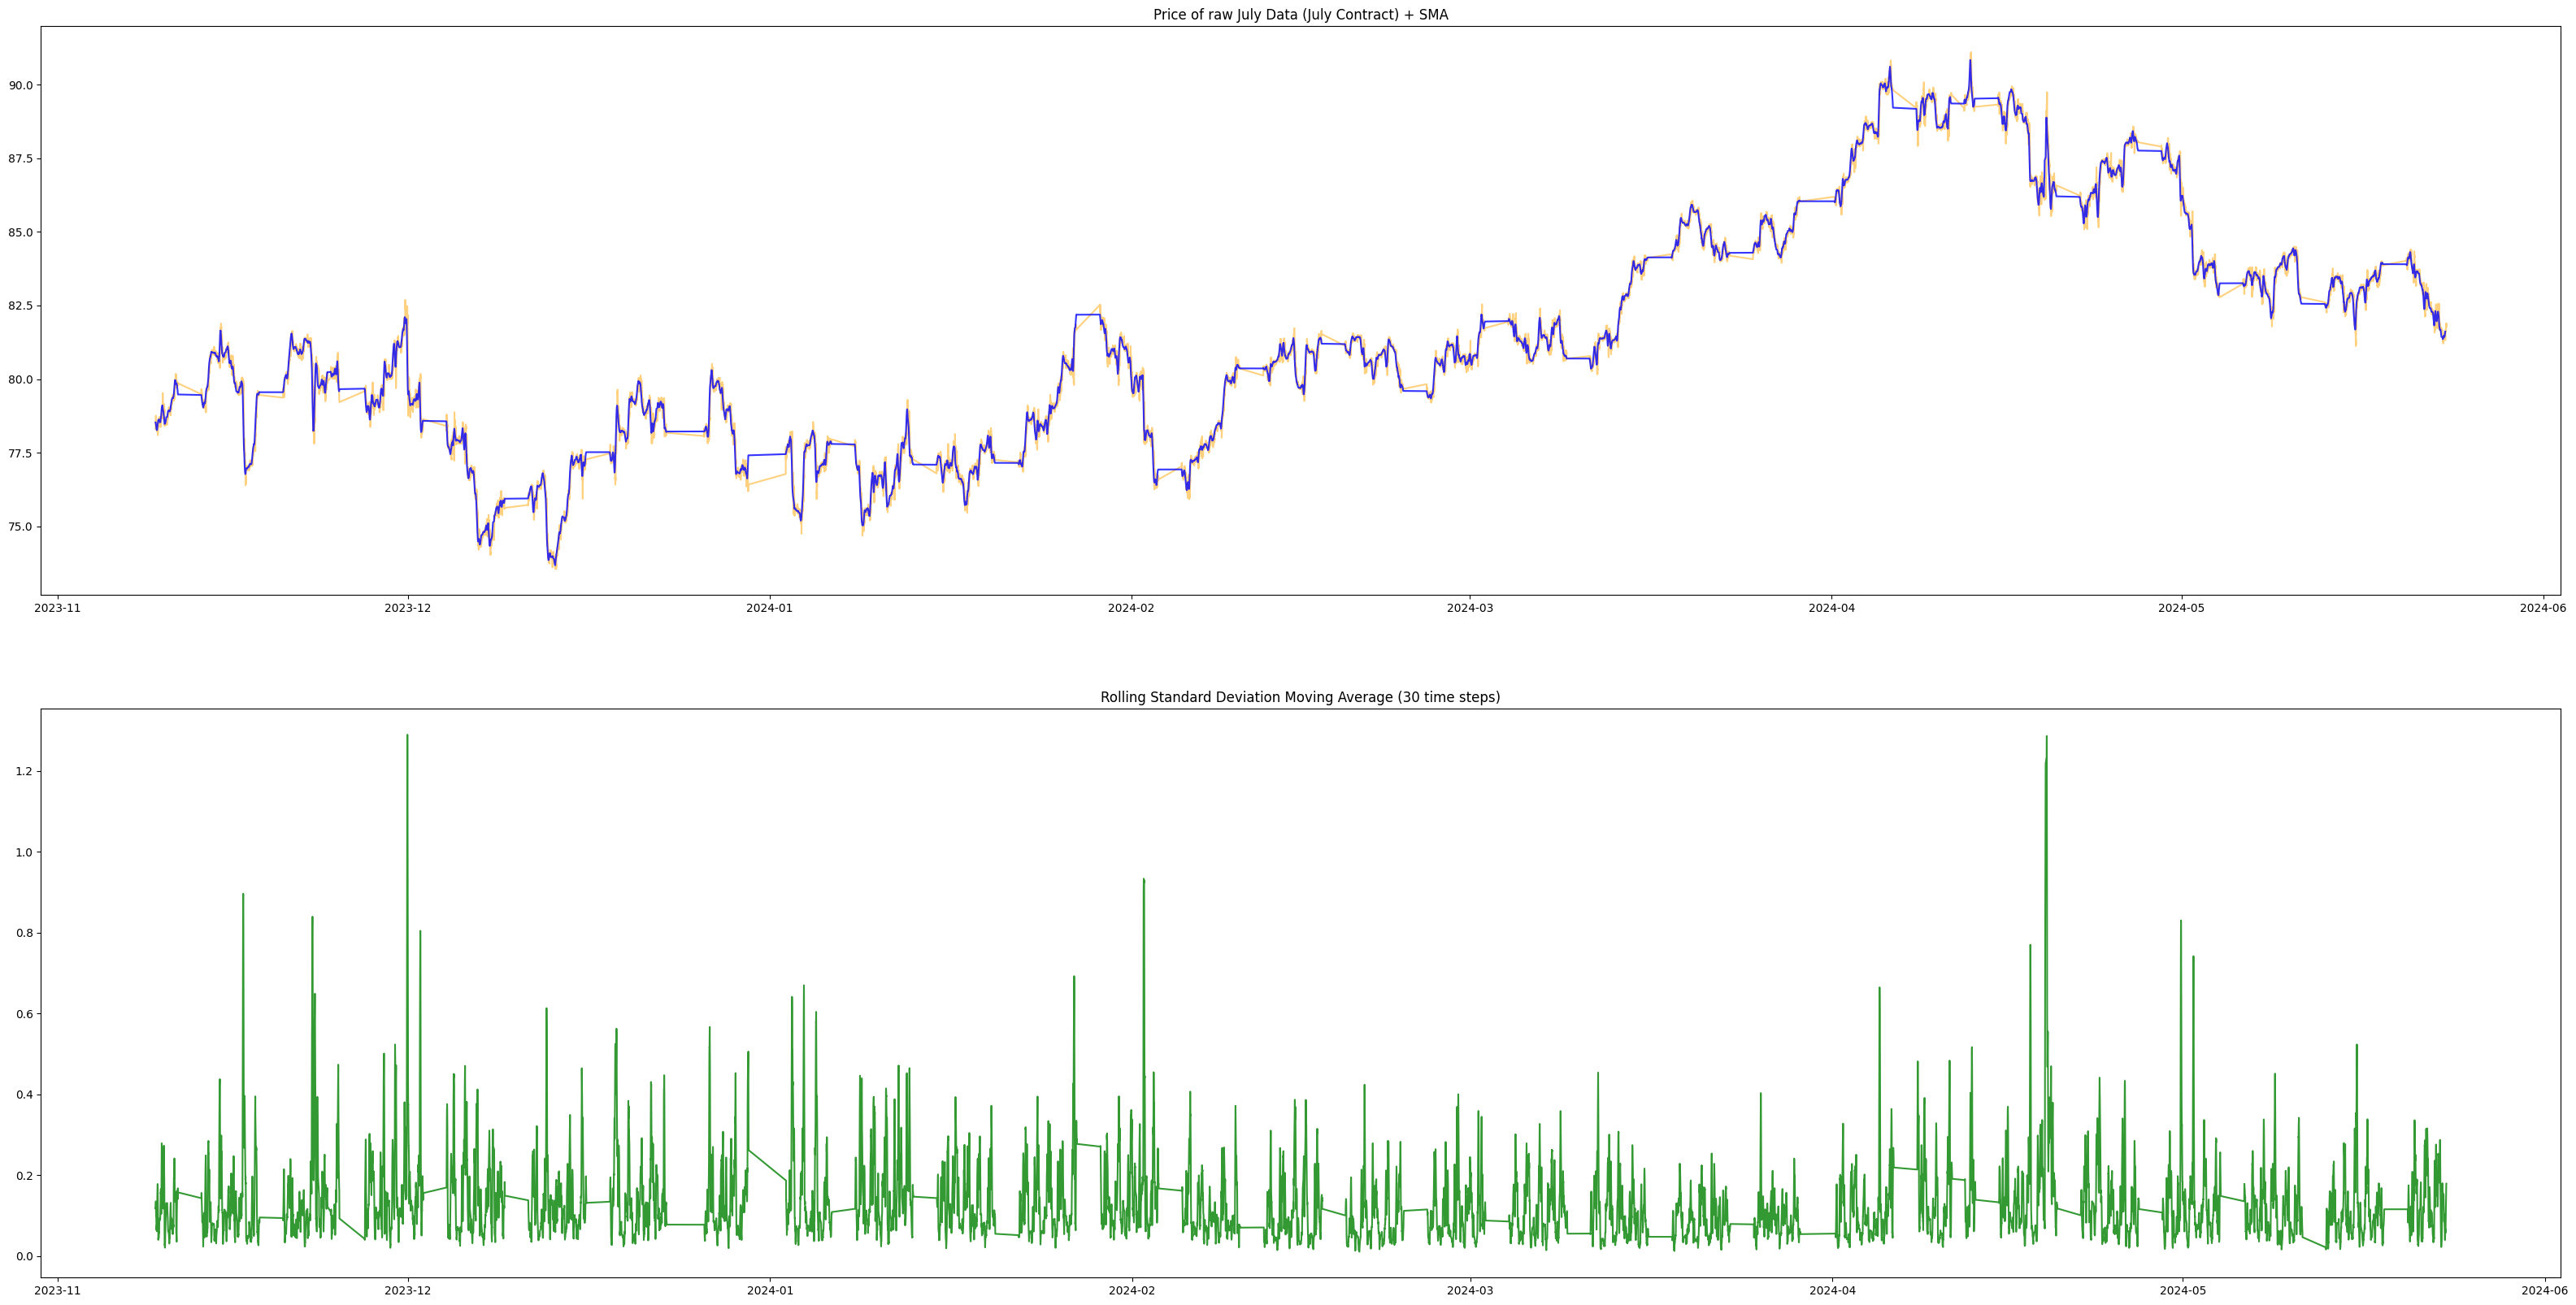

In [7]:
raw_july_data_cleaned['SMA_30'] = raw_july_data_cleaned['Price'].rolling(window=30).mean()
raw_july_data_cleaned['Rolling_STD_30'] = raw_july_data_cleaned['Price'].rolling(window=30).std()

plt.figure(figsize=(40, 20))
plt.subplot(2, 1, 1)

plt.plot(raw_july_data_cleaned['Timestamp'], raw_july_data_cleaned['Price'], label='Price', color='orange', alpha=0.5)
plt.plot(raw_july_data_cleaned['Timestamp'], raw_july_data_cleaned['SMA_30'], label='50 time step SMA', color='blue', alpha=0.8)
plt.title("Price of raw July Data (July Contract) + SMA")

plt.subplot(2, 1, 2)
plt.plot(raw_july_data_cleaned['Timestamp'], raw_july_data_cleaned['Rolling_STD_30'], label='30-min Rolling STD', color='green', alpha=0.8)
plt.title("Rolling Standard Deviation Moving Average (30 time steps)")


In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose


In [9]:
# Set the timestamp as the index for the decomposition
raw_july_data_cleaned.set_index('Timestamp', inplace=True)

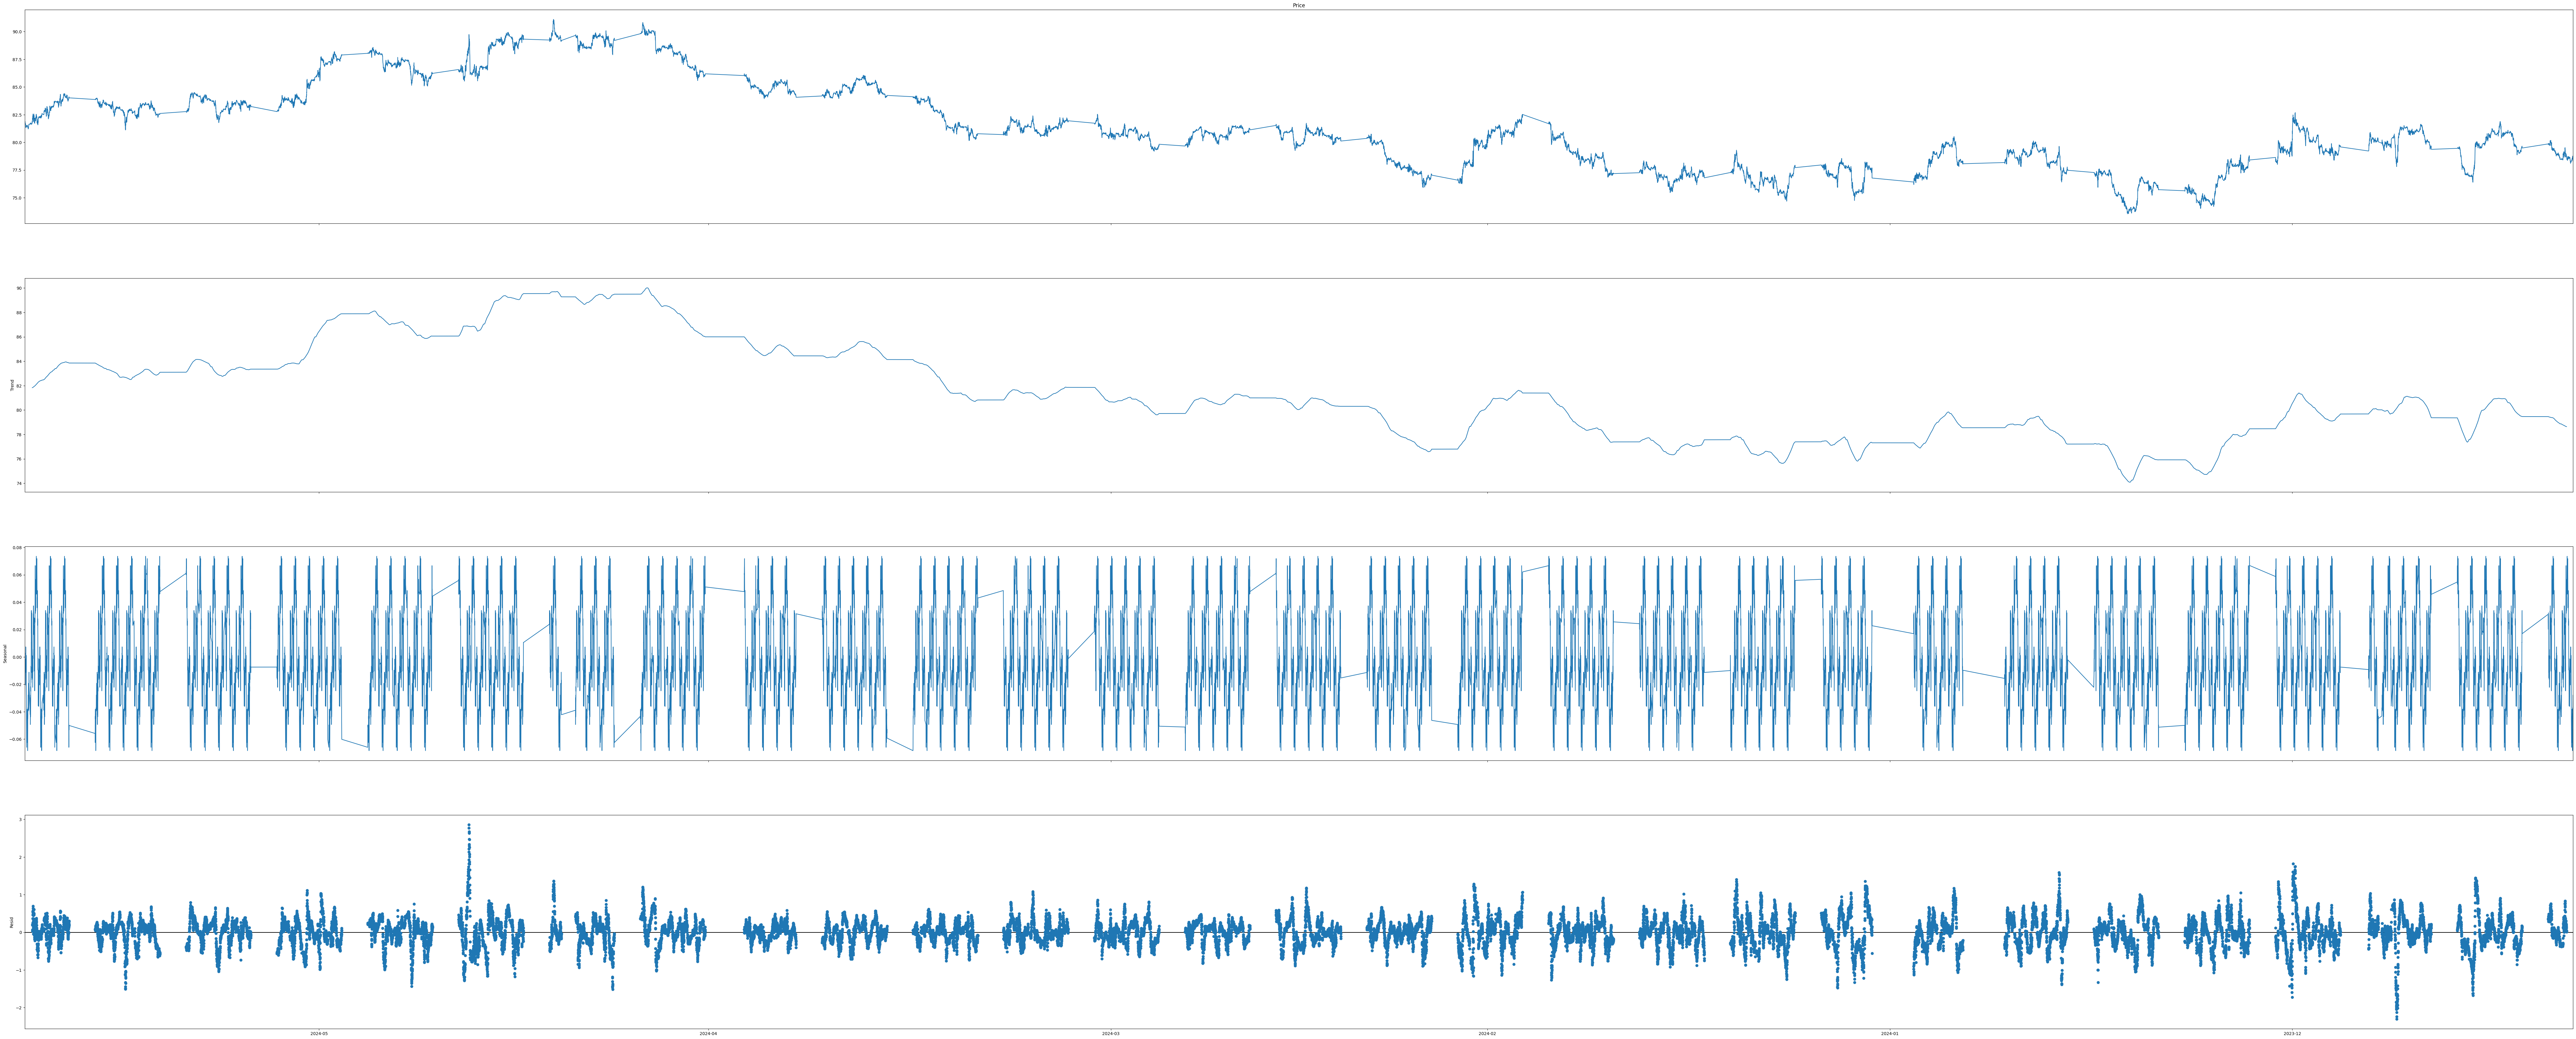

In [10]:
# Decomposition in a period of 60 minutes
decomposition = seasonal_decompose(raw_july_data_cleaned['Price'], model='additive', period=288)

fig = decomposition.plot()
fig.set_size_inches(100, 40)
plt.show()

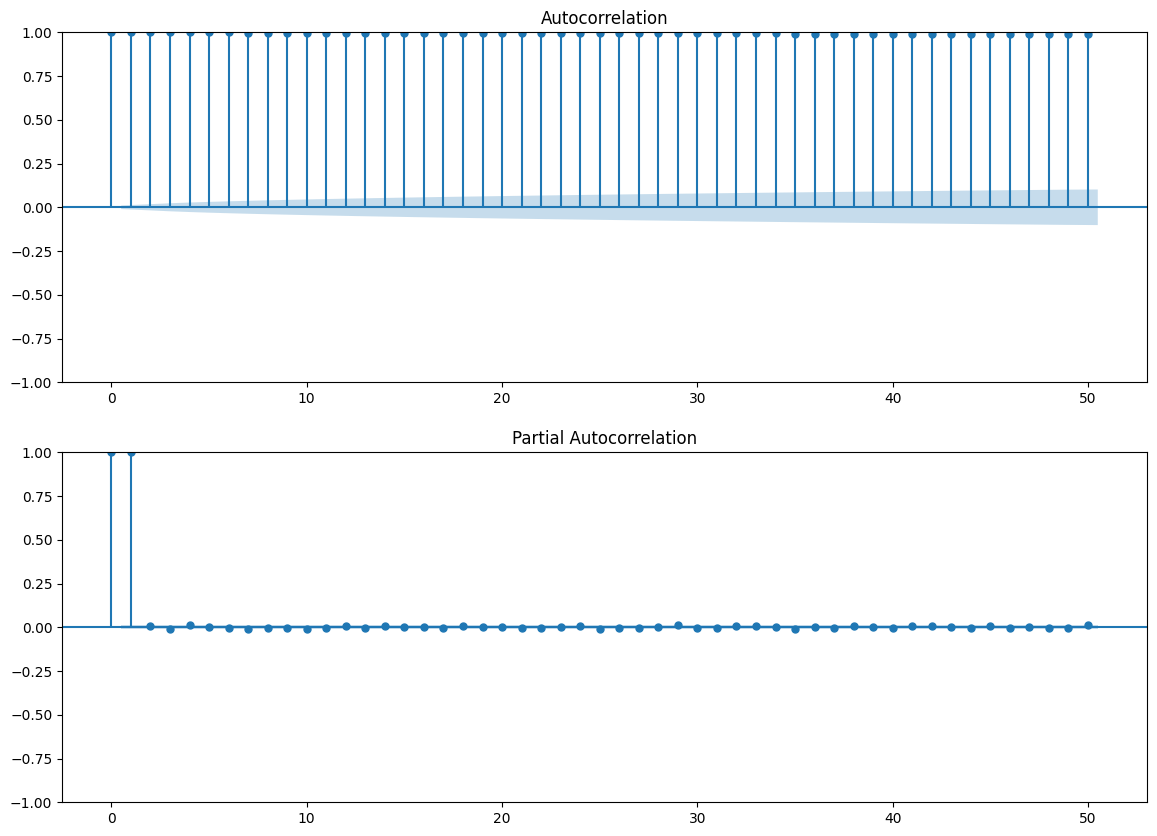

In [11]:
import statsmodels.api as sm

# Plot the ACF and PACF
fig, ax = plt.subplots(2, 1, figsize=(14, 10))

sm.graphics.tsa.plot_acf(raw_july_data_cleaned['Price'], lags=50, ax=ax[0])
sm.graphics.tsa.plot_pacf(raw_july_data_cleaned['Price'], lags=50, ax=ax[1])

plt.show()


In [12]:
# Analyse the trends of the days
# 1. Take the difference between t and t - 1 / t - 1 to find out the percentage price change and movement for each 5 minute interval >> calculating the returns

raw_july_data_cleaned["PriceDiffDay"]
raw_july_data_cleaned["PriceDiffHour"]
raw_july_data_cleaned["PriceDiffMinute"] = (raw_july_data_cleaned["Price"] - raw_july_data_cleaned.shift(1)["Price"]) / raw_july_data_cleaned.shift(1)["Price"] * 100

# 2. Obtain Information about specific day and time range
#Remember that Monday is 0 indexed
raw_july_data_cleaned["Day"] = raw_july_data_cleaned.index.day_of_week
raw_july_data_cleaned["Hour"] = raw_july_data_cleaned.index.hour
raw_july_data_cleaned["Minute"] = raw_july_data_cleaned.index.minute


In [66]:
#Calculate Daily Returns, its mean and standard deviation
daily_prices = raw_july_data_cleaned['Price'].resample('D').last()
daily_prices = daily_prices.dropna()

daily_prices = ((daily_prices - daily_prices.shift(1)) / daily_prices.shift(1) * 100)
daily_diff_df = pd.DataFrame({"DailyReturns": daily_prices.values}, index = daily_prices.index)
daily_diff_df['DayOfWeek'] = daily_diff_df.index.day_name()
grouped_by_day = daily_diff_df.groupby('DayOfWeek').agg(['mean', 'std', 'min', 'max'])

#Restructuring table to increase readability + sort the days
grouped_by_day.columns = ['_'.join(col) for col in grouped_by_day.columns]
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
grouped_by_day = grouped_by_day.reindex(day_order)

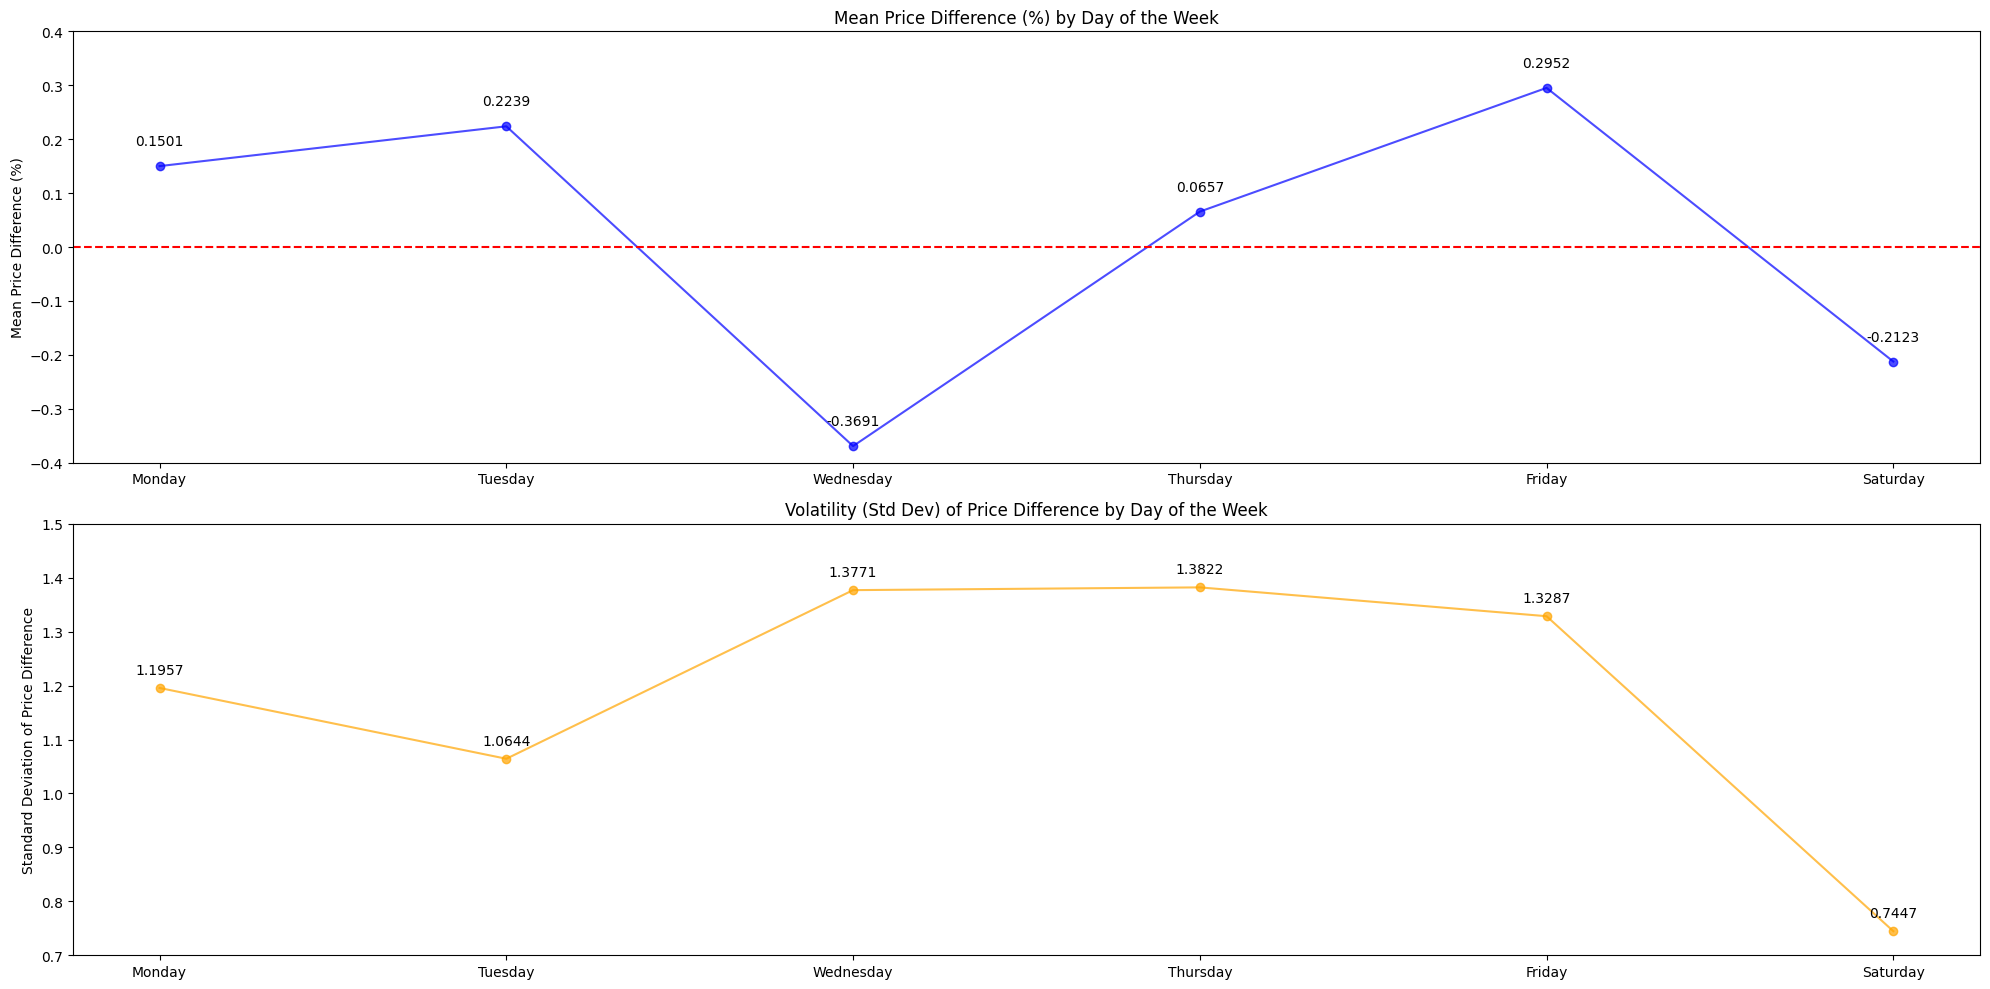

In [84]:
plt.figure(figsize=(20, 10))

plt.subplot(2, 1, 1)
plt.plot(grouped_by_day.index, grouped_by_day['DailyReturns_mean'], color='blue', alpha=0.7, marker = "o")
plt.ylabel('Mean Price Difference (%)')
plt.title('Mean Price Difference (%) by Day of the Week')
plt.ylim(-0.4, 0.4)
plt.axhline(y=0, color='red', linestyle='--')
for i in range(len(grouped_by_day)):
    plt.annotate(f'{grouped_by_day["DailyReturns_mean"].iloc[i]:.4f}',
                 xy=(grouped_by_day.index[i], grouped_by_day['DailyReturns_mean'].iloc[i]),
                 xytext=(0, 15), textcoords='offset points', ha='center')

plt.subplot(2, 1, 2)
plt.plot(grouped_by_day.index, grouped_by_day['DailyReturns_std'], color='orange', alpha=0.7, marker = "o")
plt.ylabel('Standard Deviation of Price Difference')
plt.title('Volatility (Std Dev) of Price Difference by Day of the Week')
plt.ylim(0.7, 1.5)
for i in range(len(grouped_by_day)):
    plt.annotate(f'{grouped_by_day["DailyReturns_std"].iloc[i]:.4f}',
                 xy=(grouped_by_day.index[i], grouped_by_day['DailyReturns_std'].iloc[i]),
                 xytext=(0, 10), textcoords='offset points', ha='center')

plt.tight_layout()
plt.show()

In [89]:
#Calculate Hourly Returns, its mean and standard deviation
hourly_prices = raw_july_data_cleaned['Price'].resample('h').last().dropna()
hourly_prices = hourly_prices.dropna()
hourly_returns = hourly_prices.pct_change().dropna() * 100

hourly_diff_df = pd.DataFrame({"HourlyReturns": hourly_returns.values}, index=hourly_returns.index)

#Restructuring Hour Code
hourly_diff_df['HourOfDay'] = hourly_diff_df.index.hour
grouped_by_hour = hourly_diff_df.groupby('HourOfDay').agg(['mean', 'std', 'min', 'max'])
grouped_by_hour.columns = ['_'.join(col) for col in grouped_by_hour.columns]


           HourlyReturns_mean  HourlyReturns_std  HourlyReturns_min  \
HourOfDay                                                             
0                   -0.020949           0.446994          -1.570485   
1                   -0.013133           0.471737          -2.967211   
2                    0.008478           0.394704          -2.234149   
3                   -0.023920           0.245712          -0.709043   
4                   -0.018815           0.176540          -1.018740   
5                    0.003279           0.117195          -0.276521   
6                   -0.003323           0.158724          -0.601269   
7                    0.041769           0.225106          -0.513049   
8                   -0.001823           0.188622          -0.695769   
9                    0.036287           0.354622          -0.928635   
10                   0.000154           0.161149          -0.416017   
11                   0.002503           0.135274          -0.673552   
12    

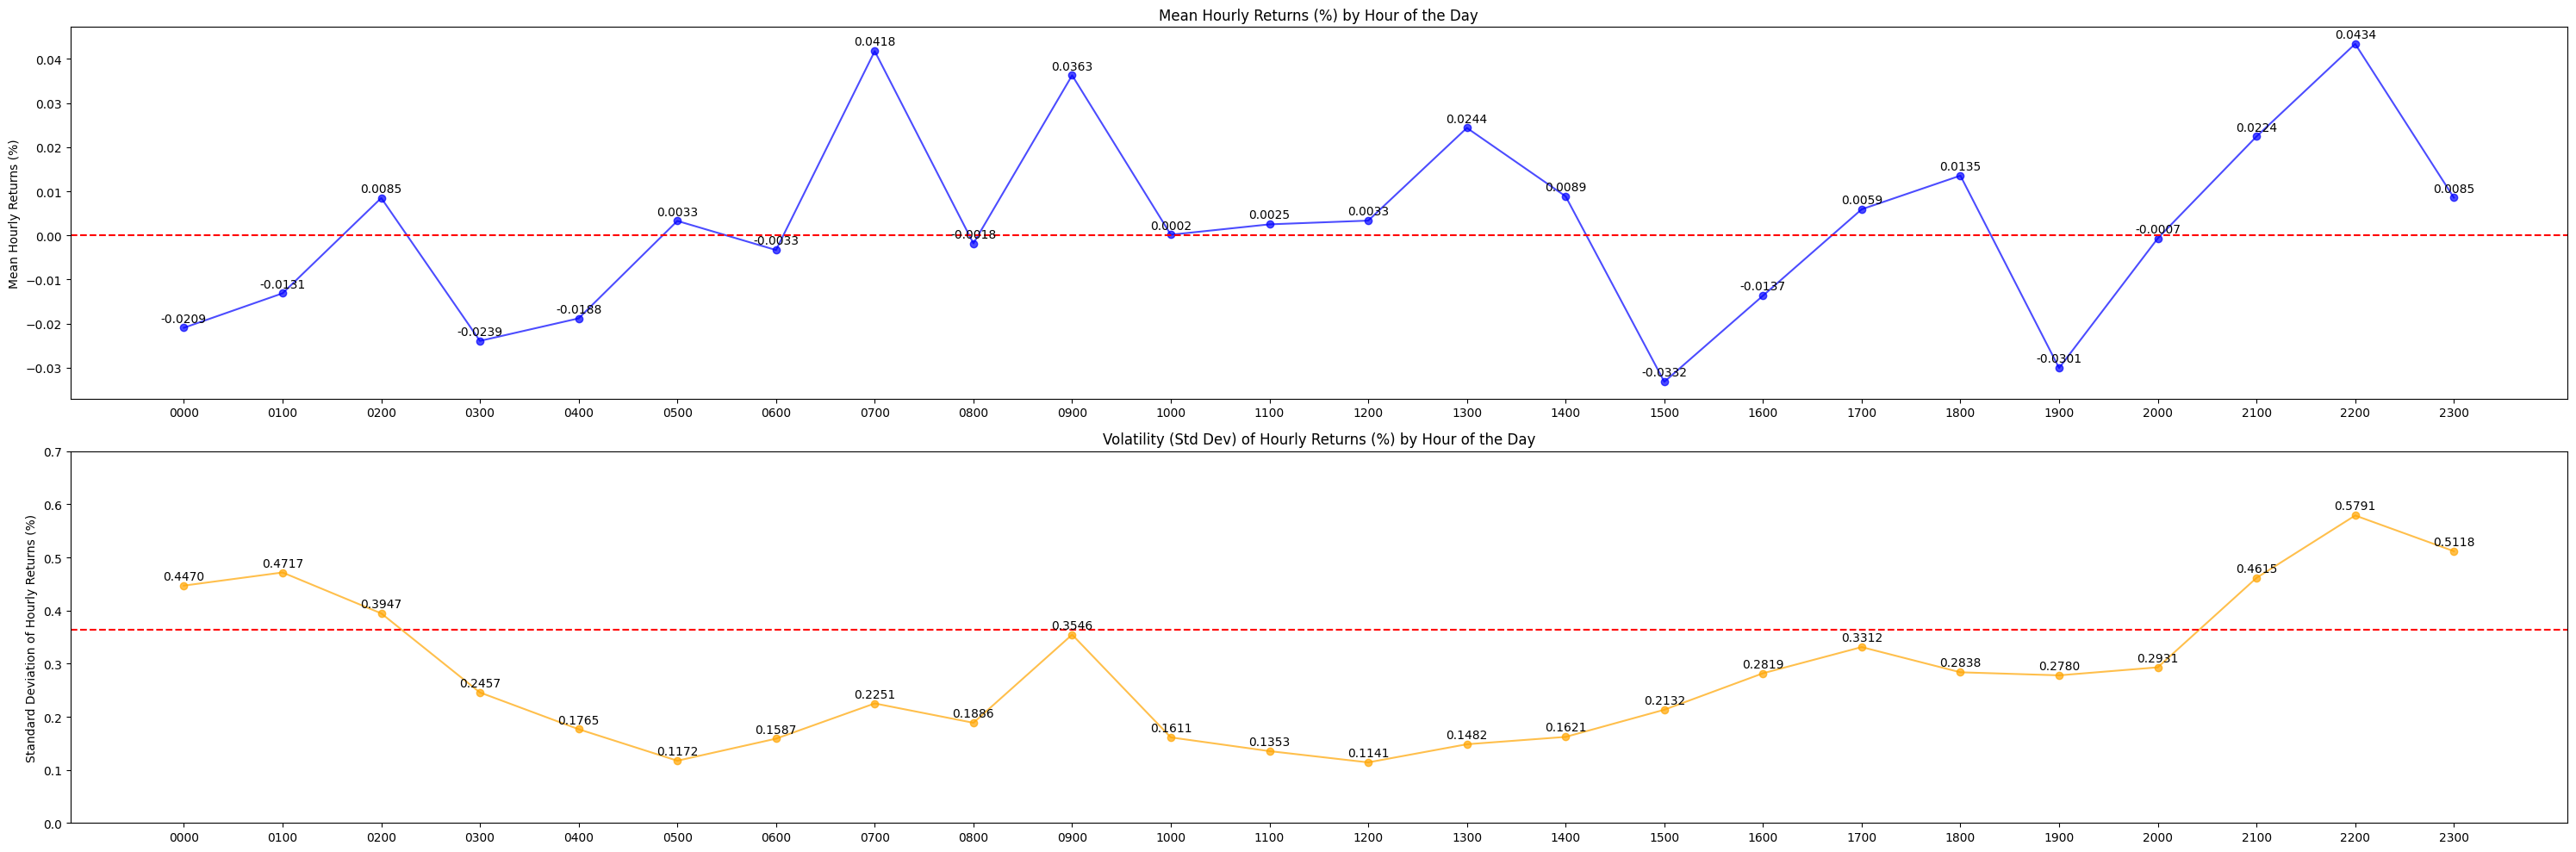

In [112]:
# Plot the mean and standard deviation of hourly returns for each hour of the day
hours = ["0000", "0100", "0200", "0300", "0400", "0500", "0600", "0700", "0800", "0900", "1000", "1100", "1200", "1300", "1400", "1500", "1600", "1700", "1800", "1900", "2000", "2100", "2200", "2300"]

plt.figure(figsize=(30, 10))

# Plot mean hourly returns
plt.subplot(2, 1, 1)
plt.plot(grouped_by_hour.index, grouped_by_hour['HourlyReturns_mean'], color='blue', alpha=0.7, marker='o')
plt.axhline(y=0, color='red', linestyle='--')  
plt.xticks(grouped_by_hour.index, labels=hours)
plt.ylabel('Mean Hourly Returns (%)')
plt.title('Mean Hourly Returns (%) by Hour of the Day')

# Annotate the mean hourly returns values
for i in range(len(grouped_by_hour)):
    plt.annotate(f'{grouped_by_hour["HourlyReturns_mean"].iloc[i]:.4f}',
                 xy=(grouped_by_hour.index[i], grouped_by_hour['HourlyReturns_mean'].iloc[i]),
                 xytext=(0, 5), textcoords='offset points', ha='center')

# Plot standard deviation of hourly returns
plt.subplot(2, 1, 2)
plt.plot(grouped_by_hour.index, grouped_by_hour['HourlyReturns_std'], color='orange', alpha=0.7, marker='o')
plt.axhline(y=grouped_by_hour['HourlyReturns_std'].quantile(0.75), color='red', linestyle='--')
plt.xticks(grouped_by_hour.index, labels=hours)  
plt.ylabel('Standard Deviation of Hourly Returns (%)')
plt.title('Volatility (Std Dev) of Hourly Returns (%) by Hour of the Day')
plt.ylim(0, 0.7)

# Annotate the standard deviation values
for i in range(len(grouped_by_hour)):
    plt.annotate(f'{grouped_by_hour["HourlyReturns_std"].iloc[i]:.4f}',
                 xy=(grouped_by_hour.index[i], grouped_by_hour['HourlyReturns_std'].iloc[i]),
                 xytext=(0, 5), textcoords='offset points', ha='center')

plt.tight_layout()
plt.show()

In [99]:
# 5min interval stats
five_min_prices = raw_july_data_cleaned['Price'].resample('5T').last().dropna()

five_min_returns = five_min_prices.pct_change().dropna() * 100

five_min_diff_df = pd.DataFrame({"FiveMinReturns": five_min_returns.values}, index=five_min_returns.index)
five_min_diff_df['TimeOfDay'] = five_min_diff_df.index.time
grouped_by_five_min = five_min_diff_df.groupby('TimeOfDay').agg(['mean', 'std'])

grouped_by_five_min.columns = ['_'.join(col) for col in grouped_by_five_min.columns]
print(grouped_by_five_min)


           FiveMinReturns_mean  FiveMinReturns_std
TimeOfDay                                         
00:00:00              0.001101            0.131172
00:05:00              0.008136            0.139606
00:10:00             -0.007867            0.146286
00:15:00             -0.014002            0.142628
00:20:00              0.011476            0.137623
...                        ...                 ...
23:35:00             -0.002797            0.151743
23:40:00              0.002638            0.145184
23:45:00             -0.005032            0.139198
23:50:00             -0.001194            0.149481
23:55:00             -0.003449            0.137311

[288 rows x 2 columns]


C:\Users\Tay Han\AppData\Local\Temp\ipykernel_66684\1227261633.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  five_min_prices = raw_july_data_cleaned['Price'].resample('5T').last().dropna()


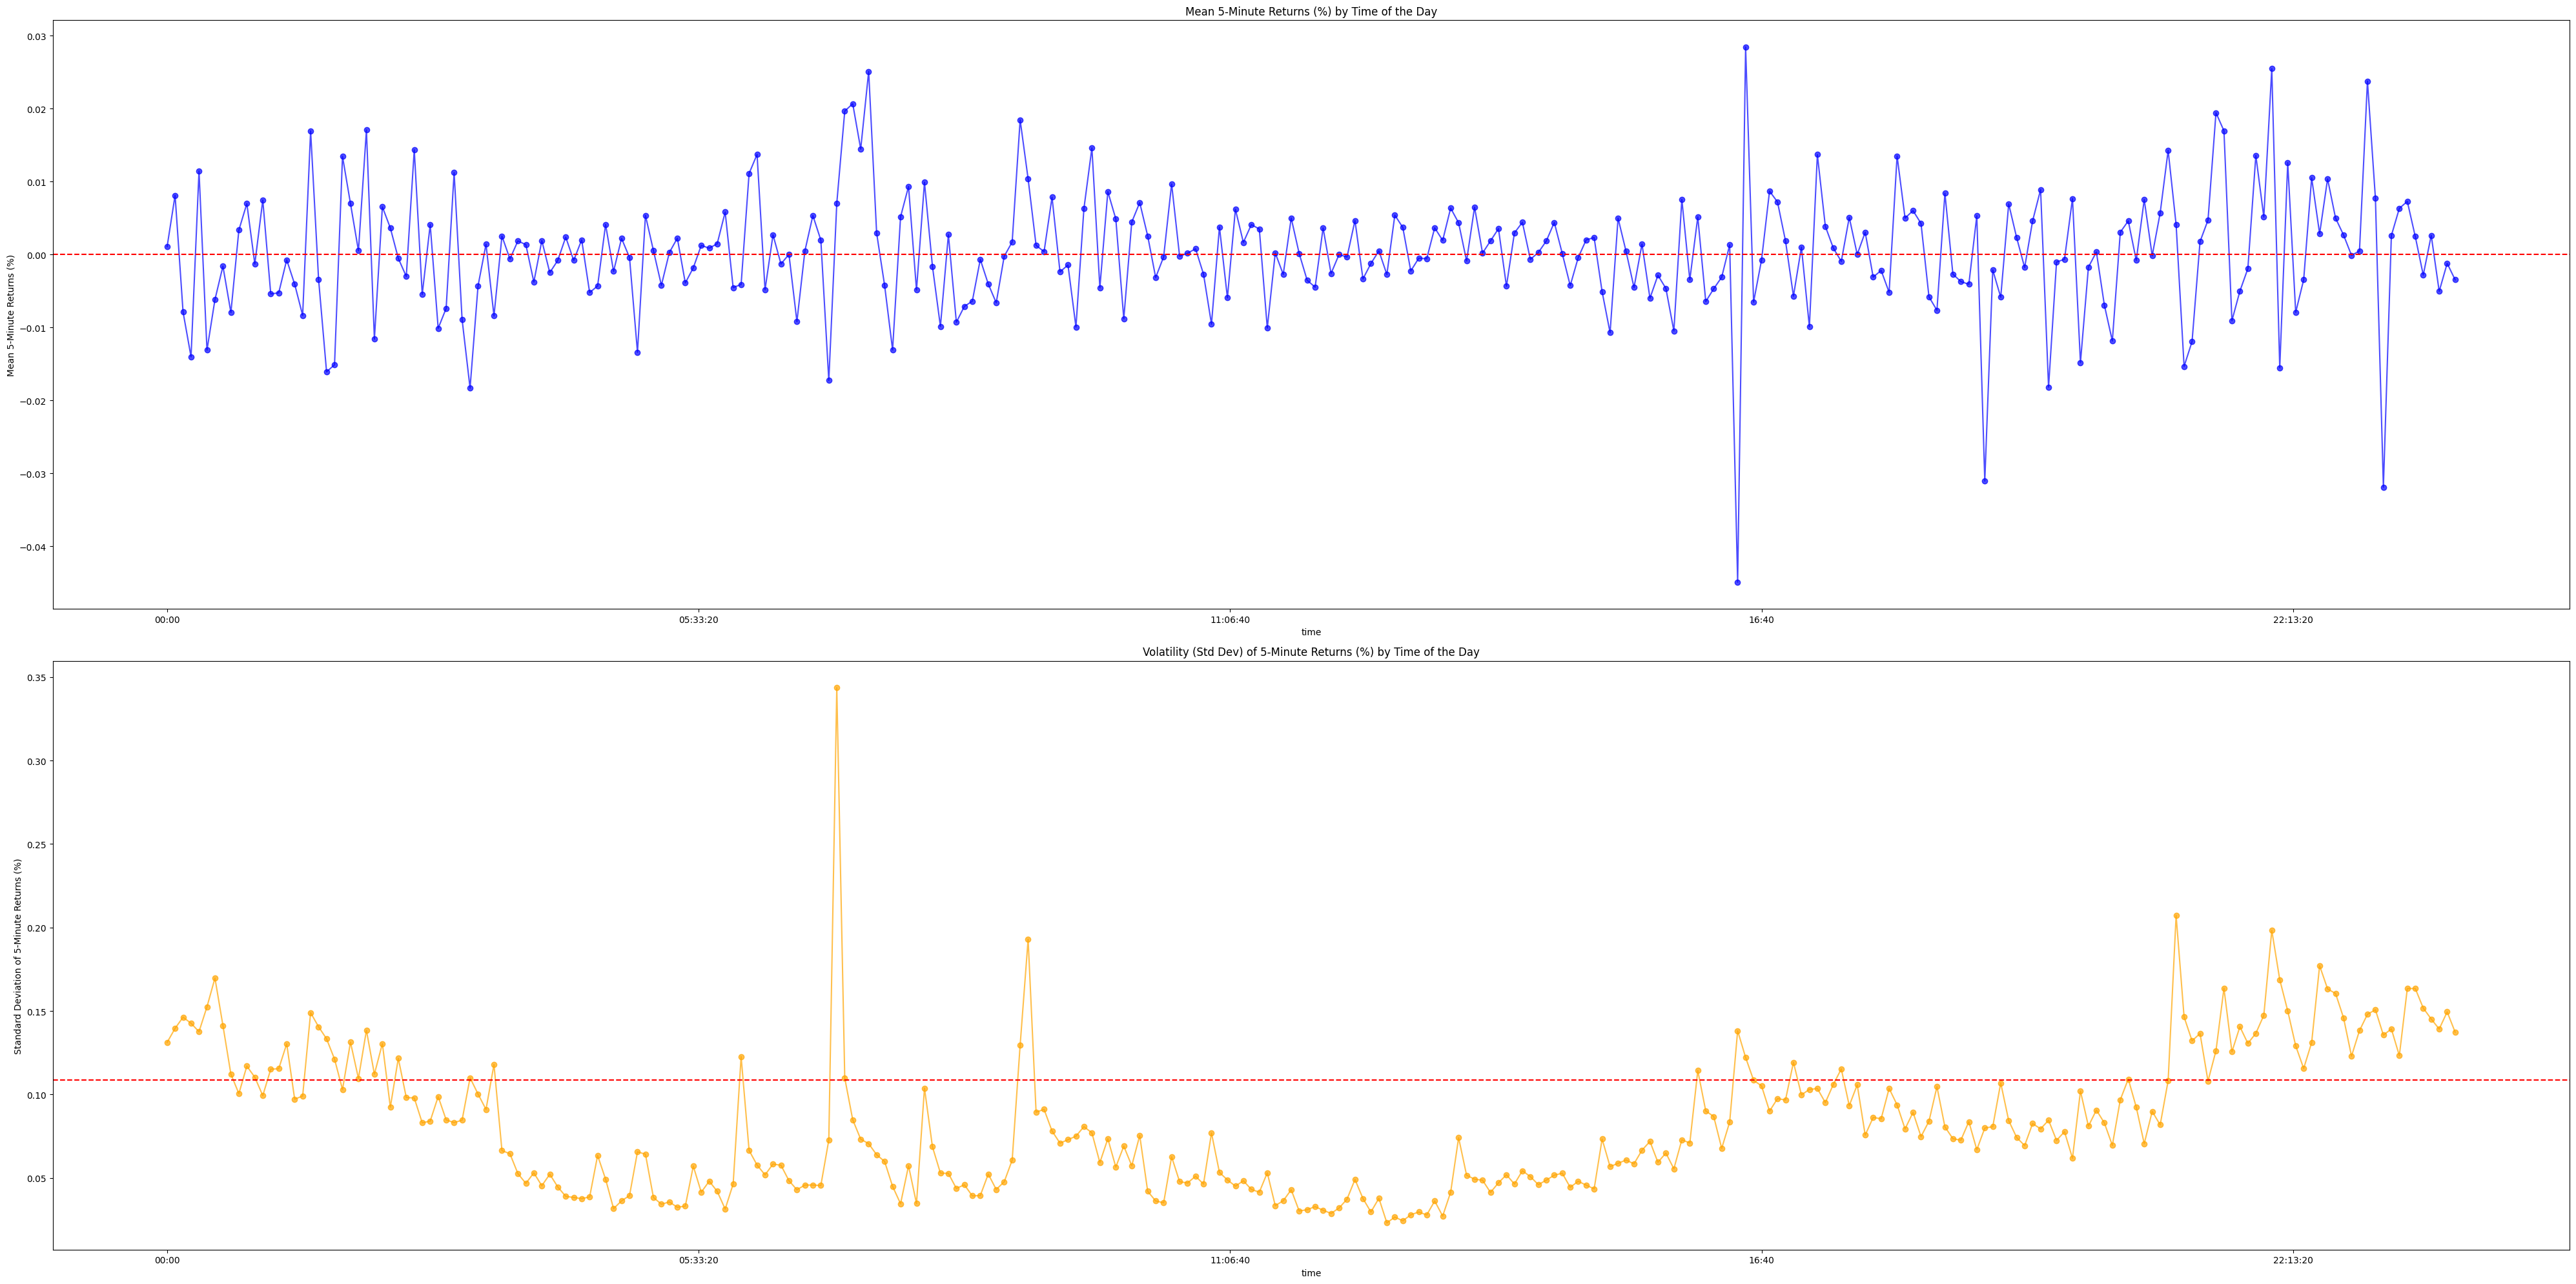

In [111]:
plt.figure(figsize=(40, 20))

# Plot mean 5-minute returns
plt.subplot(2, 1, 1)
plt.plot(grouped_by_five_min.index, grouped_by_five_min['FiveMinReturns_mean'], color='blue', alpha=0.7, marker='o')
plt.axhline(y=0, color='red', linestyle='--') 
plt.ylabel('Mean 5-Minute Returns (%)')
plt.title('Mean 5-Minute Returns (%) by Time of the Day')

# Annotate the mean 5-minute returns values
# for i in range(len(grouped_by_five_min)):
#     plt.annotate(f'{grouped_by_five_min["FiveMinReturns_mean"].iloc[i]:.4f}',
#                  xy=(grouped_by_five_min.index[i], grouped_by_five_min['FiveMinReturns_mean'].iloc[i]),
#                  xytext=(0, 5), textcoords='offset points', ha='center')

# Plot standard deviation of 5-minute returns
plt.subplot(2, 1, 2)
plt.plot(grouped_by_five_min.index, grouped_by_five_min['FiveMinReturns_std'], color='orange', alpha=0.7, marker='o')
plt.axhline(y=grouped_by_five_min['FiveMinReturns_std'].quantile(0.75), color='red', linestyle='--')
plt.ylabel('Standard Deviation of 5-Minute Returns (%)')
plt.title('Volatility (Std Dev) of 5-Minute Returns (%) by Time of the Day')

# Annotate the standard deviation values
# for i in range(len(grouped_by_five_min)):
#     plt.annotate(f'{grouped_by_five_min["FiveMinReturns_std"].iloc[i]:.4f}',
#                  xy=(grouped_by_five_min.index[i], grouped_by_five_min['FiveMinReturns_std'].iloc[i]),
#                  xytext=(0, 5), textcoords='offset points', ha='center')

plt.tight_layout()
plt.show()

                   FiveMinReturns_mean  FiveMinReturns_std
Month   TimeOfDay                                         
2023-11 00:00                -0.024092            0.111646
        00:05                -0.011677            0.147701
        00:10                -0.004391            0.094291
        00:15                -0.006544            0.117128
        00:20                 0.015271            0.109263


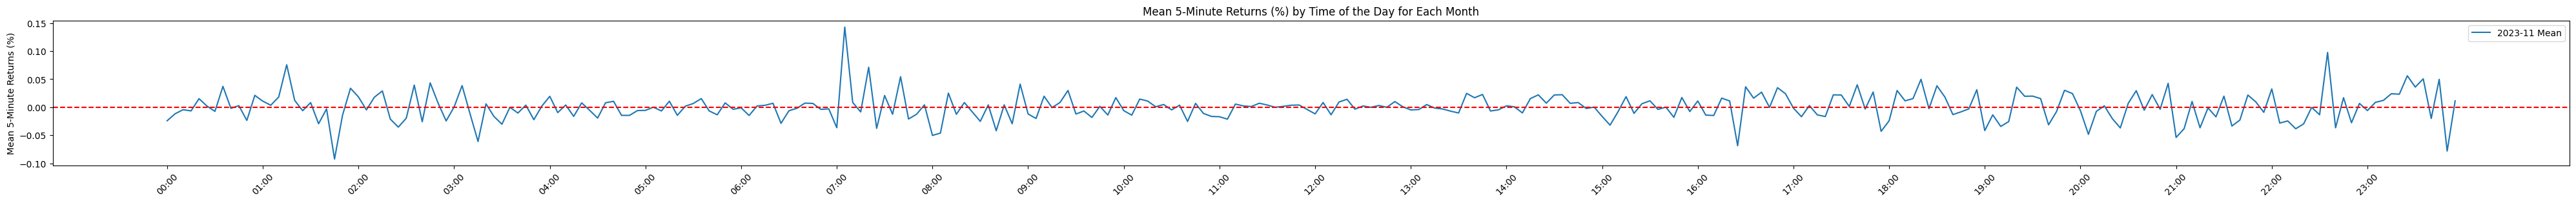

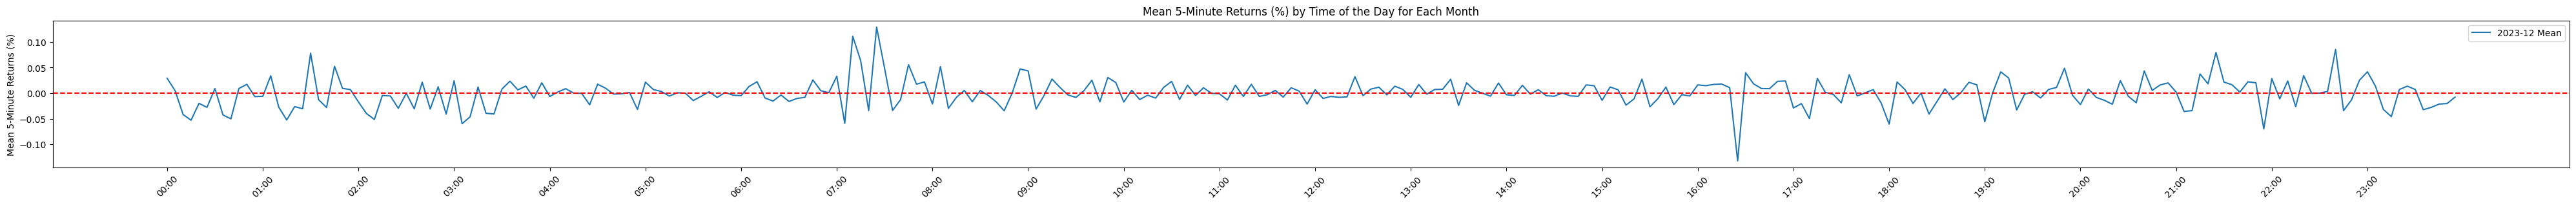

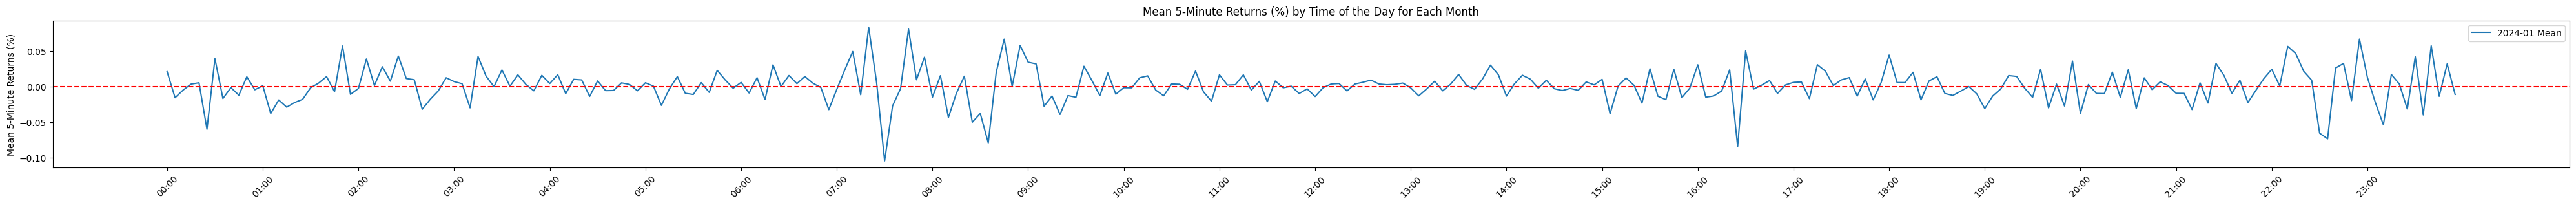

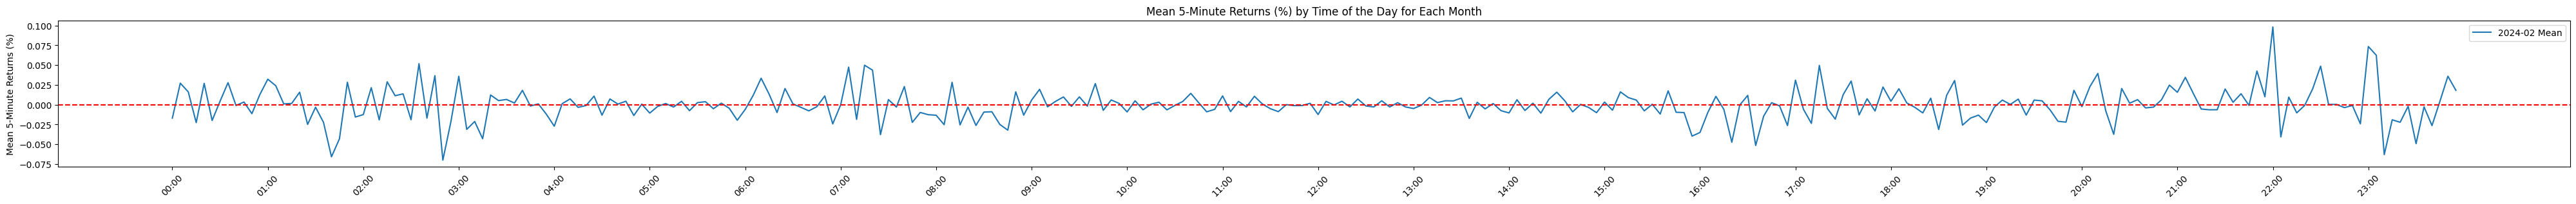

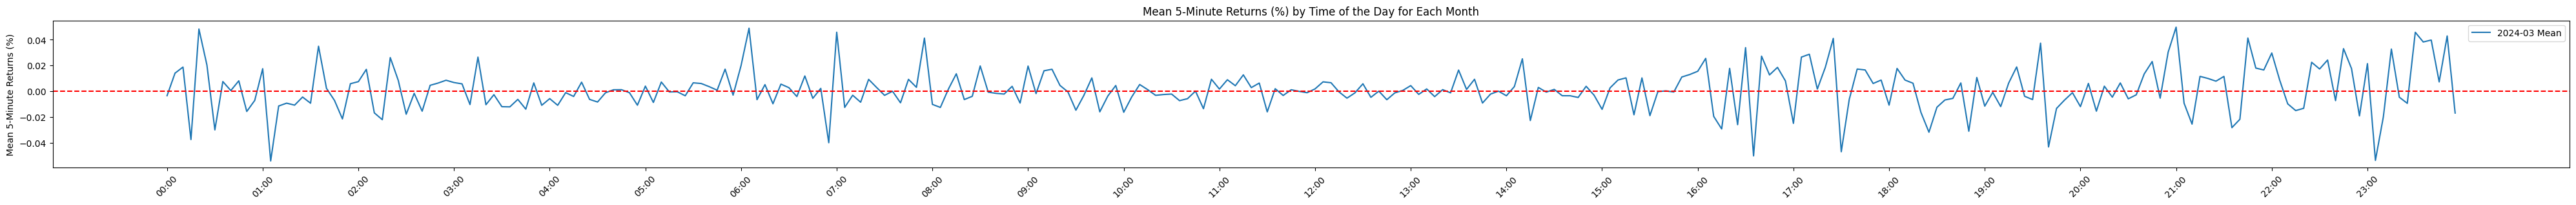

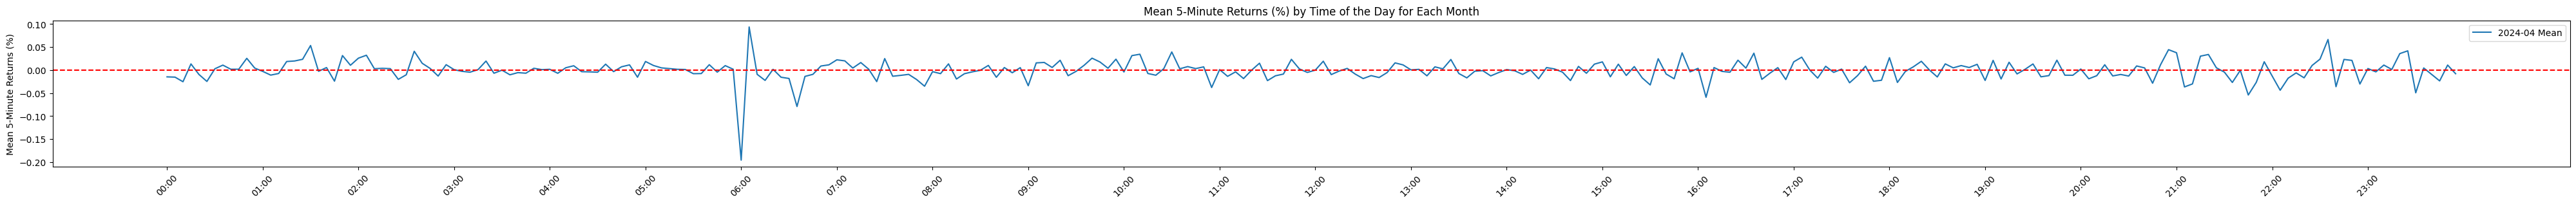

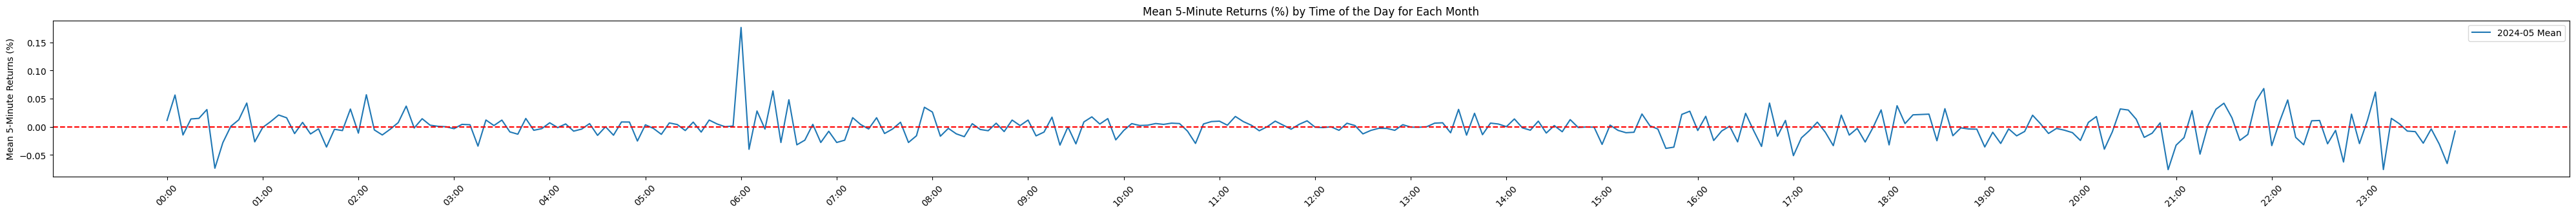

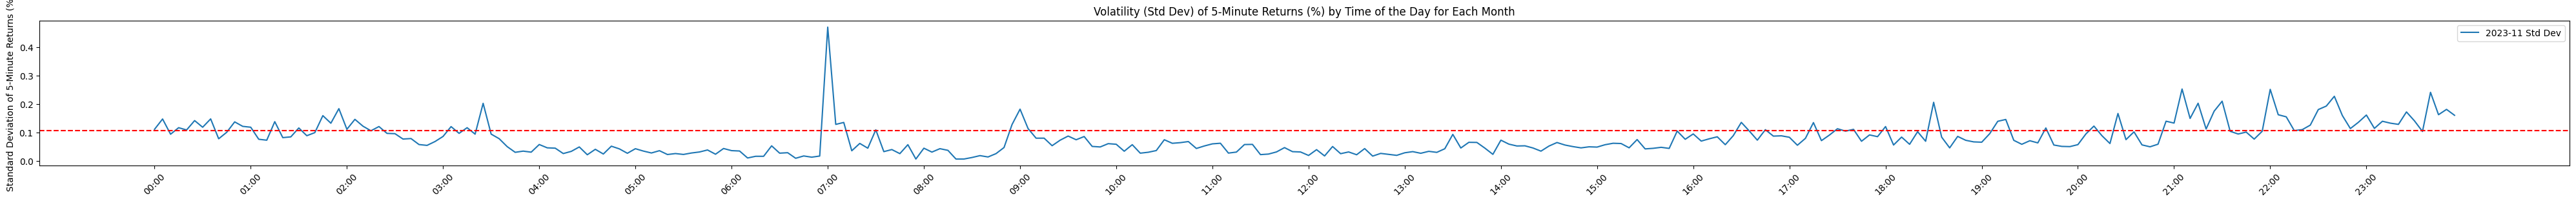

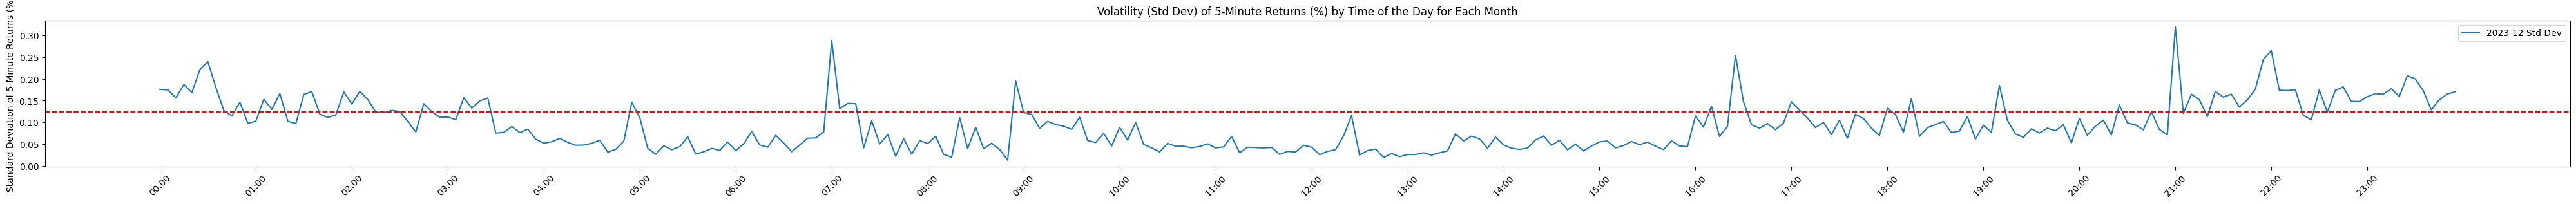

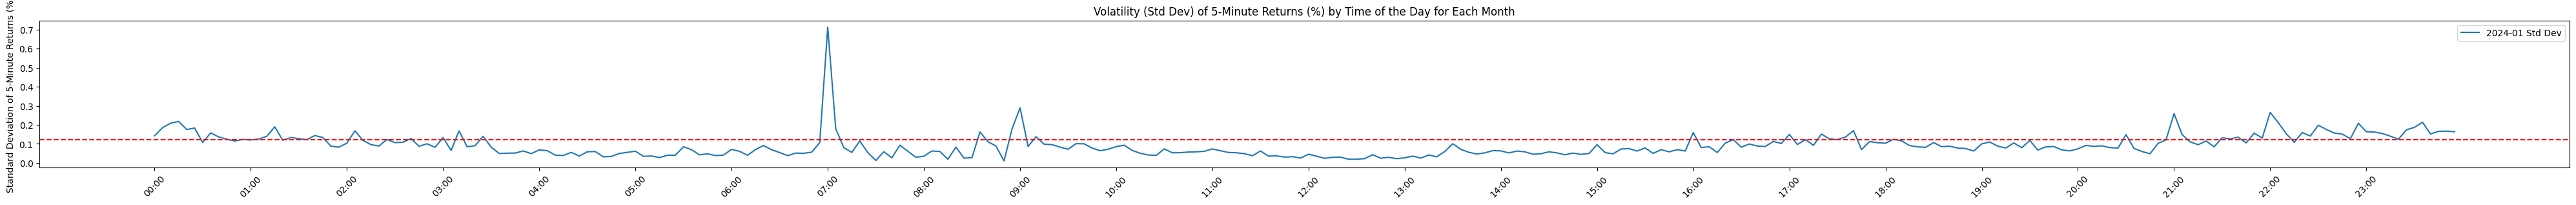

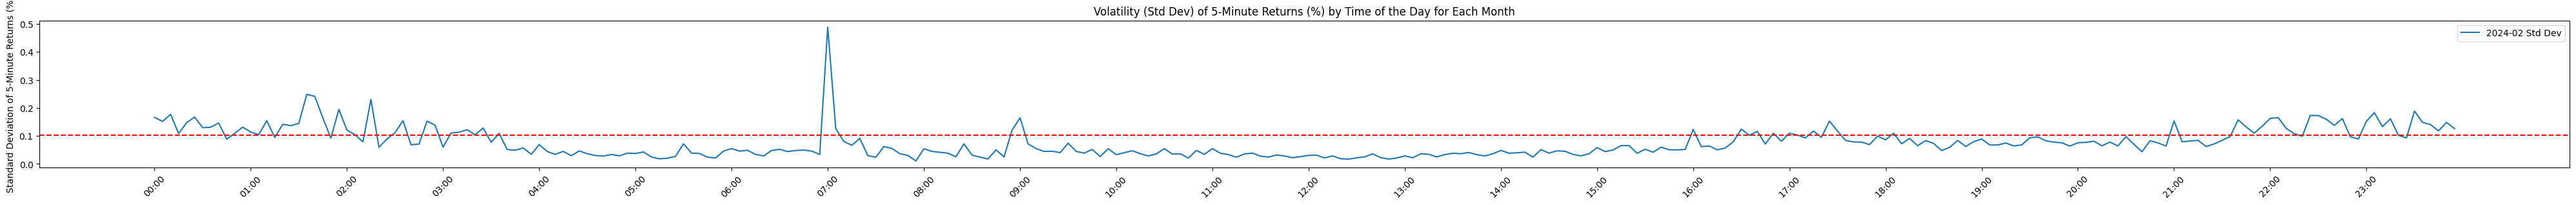

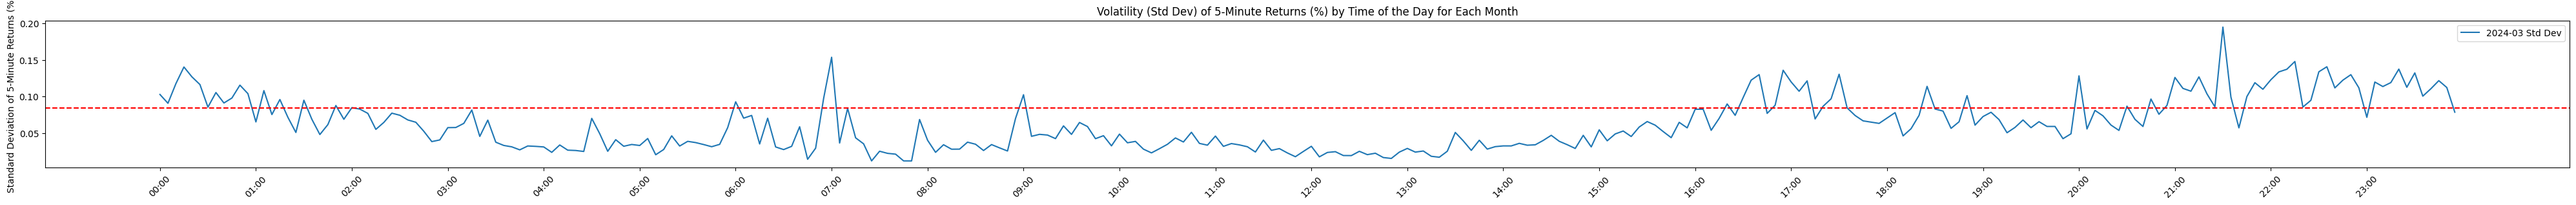

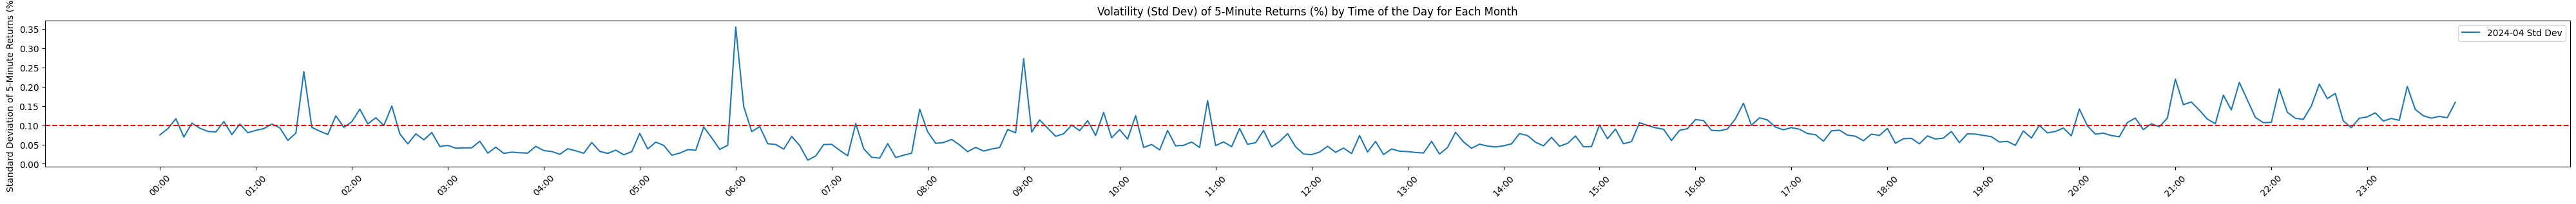

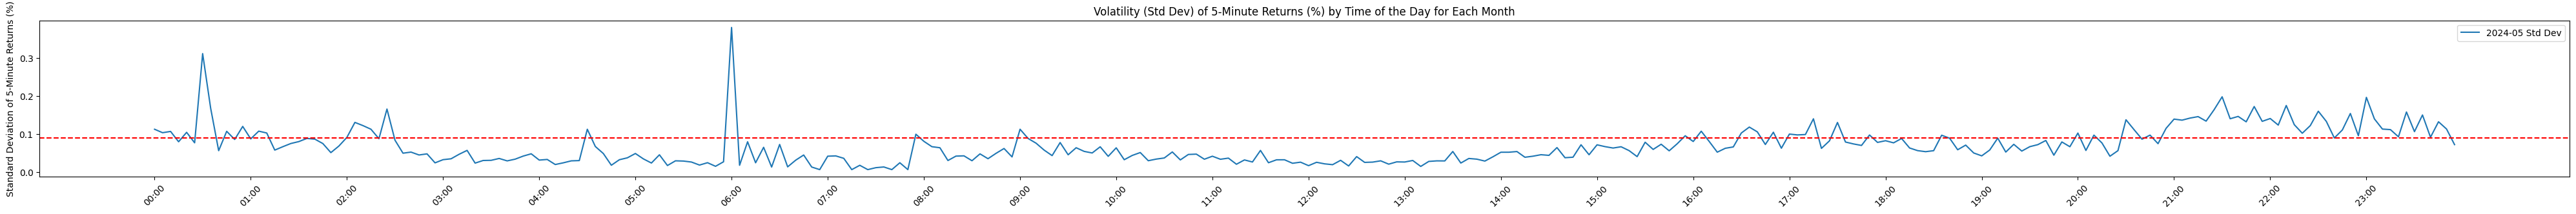

In [129]:
import numpy as np
five_min_prices = raw_july_data_cleaned['Price'].resample('5min').last().dropna()
five_min_returns = five_min_prices.pct_change().dropna() * 100
five_min_diff_df = pd.DataFrame({"FiveMinReturns": five_min_returns.values}, index=five_min_returns.index)

# Add columns for the time of day and month
five_min_diff_df['TimeOfDay'] = five_min_diff_df.index.strftime('%H:%M')
five_min_diff_df['Month'] = five_min_diff_df.index.strftime('%Y-%m')


grouped_by_time_and_month = five_min_diff_df.groupby(['Month', 'TimeOfDay']).agg(['mean', 'std'])

grouped_by_time_and_month.columns = ['_'.join(col) for col in grouped_by_time_and_month.columns]
print(grouped_by_time_and_month.head())

unique_months = grouped_by_time_and_month.index.get_level_values(0).unique()

i = 1
for month in unique_months:
    # Select data for the current month
    plt.figure(figsize=(40, 20))
    plt.subplot(7, 1, i)
    data_for_month = grouped_by_time_and_month.loc[month]
    
    # Plot mean 5-minute returns for the current month
    plt.plot(data_for_month.index, data_for_month['FiveMinReturns_mean'], label=f'{month} Mean')
    i += 1
    # Set x-ticks with better intervals
    interval = 12
    plt.xticks(np.arange(0, len(data_for_month), interval), data_for_month.index[::interval], rotation=45)

    plt.axhline(y=0, color='red', linestyle='--')  # Add horizontal line at y=0
    plt.ylabel('Mean 5-Minute Returns (%)')
    plt.title('Mean 5-Minute Returns (%) by Time of the Day for Each Month')
    plt.legend()
    plt.tight_layout()
    plt.show()


i = 1
for month in unique_months:
    # Select data for the current month
    data_for_month = grouped_by_time_and_month.loc[month]
    
    # Plot standard deviation of 5-minute returns for the current month
    plt.figure(figsize=(40, 20))
    plt.subplot(7, 1, i)
    plt.plot(data_for_month.index, data_for_month['FiveMinReturns_std'], label=f'{month} Std Dev')
    
    i += 1
    
    intervals = 12
    plt.xticks(np.arange(0, len(data_for_month), interval), data_for_month.index[::interval], rotation=45)

    plt.axhline(y=data_for_month['FiveMinReturns_std'].quantile(0.75), color='red', linestyle='--')  # Add horizontal line at y=0
    plt.ylabel('Standard Deviation of 5-Minute Returns (%)')
    plt.title('Volatility (Std Dev) of 5-Minute Returns (%) by Time of the Day for Each Month')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
# New Idea, is the price at one month cointegrated with the prices in the current month
# New Idea, can I utilise the distributions by month and conduct ANOVA tests on them?
# New Idea, Can I check if the variances of each group is equal, or can i check if the means of each group are equal

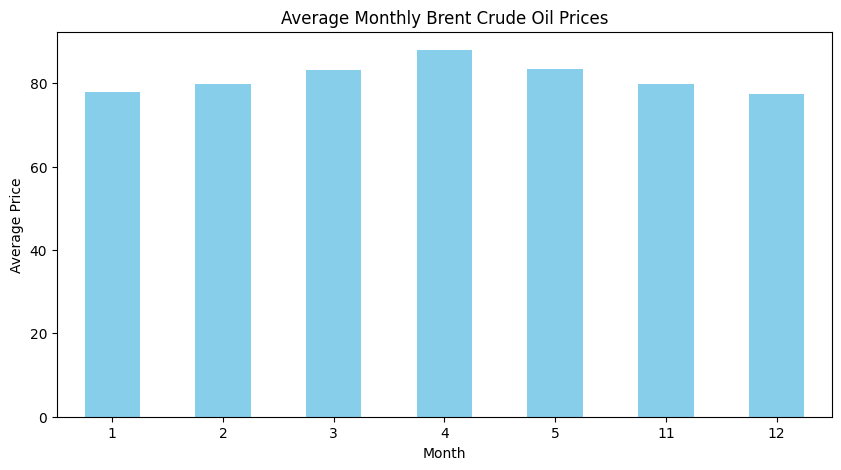

In [130]:
# Extract month and year from the index
raw_july_data_cleaned['Month'] = raw_july_data_cleaned.index.month
raw_july_data_cleaned['Year'] = raw_july_data_cleaned.index.year

# Group by month and calculate mean price
monthly_mean_prices = raw_july_data_cleaned.groupby('Month')['Price'].mean()

# Plot the seasonal trend
plt.figure(figsize=(10, 5))
monthly_mean_prices.plot(kind='bar', color='skyblue')
plt.xlabel('Month')
plt.ylabel('Average Price')
plt.title('Average Monthly Brent Crude Oil Prices')
plt.xticks(rotation=0)
plt.show()
